<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/ycseong07/SI_ML/blob/main/4_resutls.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ycseong07/SI_ML/blob/main/4_results.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [7]:
## Install packages

#!pip install aif360
#!pip install shap

import pandas as pd
import numpy as np
import joblib
import sklearn
import pickle
import shap
import matplotlib.pyplot as plt

import matplotlib
import xgboost

import imblearn
from aif360.sklearn.metrics import specificity_score
from datetime import datetime
from imblearn.over_sampling import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from xgboost import XGBClassifier

In [10]:
## Check versions of packages

print(sklearn.__version__)
print(np.__version__)
print(pd.__version__)
print(joblib.__version__)
print(shap.__version__)
print(matplotlib.__version__)
print(xgboost.__version__)
print(imblearn.__version__)

1.0.2
1.19.5
1.3.5
1.1.0
0.40.0
3.2.2
0.90
0.9.0


# Load data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
sample_over = pd.read_csv('/content/gdrive/My Drive/성은이파이썬/ICT_ML/data/train_over_adasyn.csv')
sample_over = sample_over.drop('Unnamed: 0', axis=1)

test_2014 = pd.read_csv('/content/gdrive/My Drive/성은이파이썬/ICT_ML/data/2014_NSOK_test_preprocessed_2.csv')
test_2014 = test_2014.drop('Unnamed: 0', axis=1)

In [5]:
print(sample_over.shape)
print(test_2014.shape)

(12940, 177)
(3085, 177)


In [6]:
X_train = sample_over.drop('suicide', axis=1)
y_train = sample_over['suicide']

X_test = test_2014.drop('suicide', axis=1)
y_test = test_2014['suicide']

# Model performance

## Internal Validation Using 2014_validation_set

In [23]:
# model_file_path = "/content/gdrive/My Drive/성은이파이썬/ICT_ML/model/2014_over_model_LR.model"  
# result = joblib.load(model_file_path)

# model_file_path = "/content/gdrive/My Drive/성은이파이썬/ICT_ML/model/2014_over_model_RF.model"  
# result = joblib.load(model_file_path)

# model_file_path = "/content/gdrive/My Drive/성은이파이썬/ICT_ML/model/2014_over_model_MLP.model"  
# result = joblib.load(model_file_path)

# model_file_path = "/content/gdrive/My Drive/성은이파이썬/ICT_ML/model/2014_over_model_SVC.model"  
# result = joblib.load(model_file_path)

model_file_path = "/content/gdrive/My Drive/성은이파이썬/ICT_ML/model/2014_over_model_XGB.model"
result = joblib.load(model_file_path)

In [24]:
# Check models's params

print(result.best_params_)

{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 13, 'min_child_weight': 0, 'n_estimators': 3000, 'reg_alpha': 1e-05, 'scale_pos_weight': 1, 'subsample': 0.56}


In [25]:
y_train_prob = result.predict_proba(X_train.values)
y_train_pred = result.predict(X_train.values)

In [26]:
# Optimal Threshold for Precision-Recall Curve (maximizing f1-score)

y_test_prob = result.predict_proba(X_test.values)

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob[:,1])

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.377903, F-Score=0.335


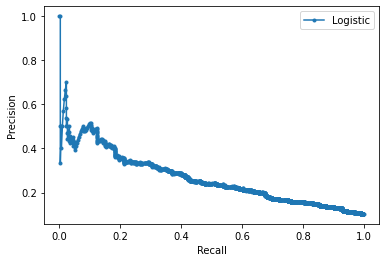

In [27]:
# PR Curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [28]:
y_test_prob = result.predict_proba(X_test.values)
y_test_pred  = (y_test_prob[:,1] >= thresholds[ix]).astype(bool)

In [29]:
## AUROC
print('AUROC : %.4f' % metrics.roc_auc_score(y_test, y_test_prob[:, 1]))

## AUPRC
print('AUPRC : %.4f' % metrics.average_precision_score(y_test, y_test_prob[:, 1]))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_test_pred)
print('F1-Score : %.4f' % f1)

# cohen's kappa score
kappa = cohen_kappa_score(y_test, y_test_pred)
print('Kappa : %.4f' % kappa)

# Sensitivity: tp / (tp + fn)
recall = recall_score(y_test, y_test_pred)
print('Recall : %.4f' % recall)

## acc
print('Accuracy : %.4f' % metrics.accuracy_score(y_test, y_test_pred))

# Specificity 
specificity = specificity_score(y_test, y_test_pred)
print('Specificity : %.4f' % specificity)

# precision tp / (tp + fp)
precision = precision_score(y_test, y_test_pred)
print('precision : %.4f' % precision)

AUROC : 0.7453
AUPRC : 0.2695
F1-Score : 0.3347
Kappa : 0.2499
Recall : 0.4000
Accuracy : 0.8454
Specificity : 0.8934
precision : 0.2878


In [30]:
# Check confusion matrix
metrics.confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None, normalize=None)

array([[2488,  297],
       [ 180,  120]])

## External Validation Using 2017_validation_set

In [43]:
data_path = '/content/gdrive/My Drive/성은이파이썬/ICT_ML/data/2017_NSOK_test_preprocessed_2.csv'

ex_val_data = pd.read_csv(data_path) ## sperater, delimiter 확인
ex_val_data = ex_val_data.drop('Unnamed: 0', axis=1)

X_ex_val = ex_val_data.drop('suicide', axis=1)
y_ex_val = ex_val_data['suicide']

In [44]:
y_train_prob = result.predict_proba(X_train.values)
y_train_pred = result.predict(X_train.values)

In [45]:
y_ex_val_prob = result.predict_proba(X_ex_val.values)

precision, recall, thresholds = precision_recall_curve(y_ex_val, y_ex_val_prob[:,1])
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

y_ex_val_pred  = (y_ex_val_prob[:,1] >= thresholds[ix]).astype(bool)

Best Threshold=0.495918, F-Score=0.290


invalid value encountered in true_divide


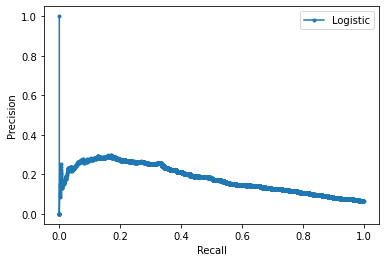

In [46]:
# PR Curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [47]:
## AUROC
print('AUROC : %.4f' % metrics.roc_auc_score(y_ex_val, y_ex_val_prob[:, 1]))

## AUPRC
print('AUPRC : %.4f' % metrics.average_precision_score(y_ex_val, y_ex_val_prob[:, 1]))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_ex_val, y_ex_val_pred)
print('F1-Score : %.4f' % f1)

# cohen's kappa score
kappa = cohen_kappa_score(y_ex_val, y_ex_val_pred)
print('Kappa : %.4f' % kappa)

# Sensitivity: tp / (tp + fn)
recall = recall_score(y_ex_val, y_ex_val_pred)
print('Recall : %.4f' % recall)

## acc
print('Accuracy : %.4f' % metrics.accuracy_score(y_ex_val, y_ex_val_pred))

# Specificity 
specificity = specificity_score(y_ex_val, y_ex_val_pred)
print('Specificity : %.4f' % specificity)

# precision tp / (tp + fp)
precision = precision_score(y_ex_val, y_ex_val_pred)
print('Precision : %.4f' % precision)

AUROC : 0.7536
AUPRC : 0.1800
Score : 0.2901
Kappa : 0.2366
Recall : 0.3302
Accuracy : 0.8990
Specificity : 0.9370
Precision : 0.2587


In [48]:
metrics.confusion_matrix(y_ex_val, y_ex_val_pred, labels=None, sample_weight=None, normalize=None)

array([[8857,  596],
       [ 422,  208]])

## External Validation Using 2020_validation_set

In [49]:
data_path = '/content/gdrive/My Drive/성은이파이썬/ICT_ML/data/2020_NSOK_test_preprocessed_2.csv'

ex_val_data = pd.read_csv(data_path) ## sperater, delimiter 확인
ex_val_data = ex_val_data.drop('Unnamed: 0', axis=1)

X_ex_val = ex_val_data.drop('suicide', axis=1)
y_ex_val = ex_val_data['suicide']

In [50]:
y_train_prob = result.predict_proba(X_train.values)
y_train_pred = result.predict(X_train.values)

In [51]:
y_ex_val_prob = result.predict_proba(X_ex_val.values)

precision, recall, thresholds = precision_recall_curve(y_ex_val, y_ex_val_prob[:,1])
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

y_ex_val_pred  = (y_ex_val_prob[:,1] >= thresholds[ix]).astype(bool)

Best Threshold=0.430465, F-Score=0.172


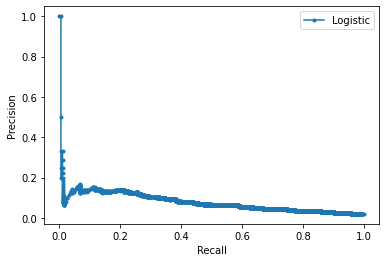

In [52]:
# PR Curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [53]:
## AUROC
print('AUROC : %.4f' % metrics.roc_auc_score(y_ex_val, y_ex_val_prob[:, 1]))

## AUPRC
print('AUPRC : %.4f' % metrics.average_precision_score(y_ex_val, y_ex_val_prob[:, 1]))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_ex_val, y_ex_val_pred)
print('F1-Score : %.4f' % f1)

# cohen's kappa score
kappa = cohen_kappa_score(y_ex_val, y_ex_val_pred)
print('Kappa : %.4f' % kappa)

# Sensitivity: tp / (tp + fn)
recall = recall_score(y_ex_val, y_ex_val_pred)
print('Recall : %.4f' % recall)

## acc
print('Accuracy : %.4f' % metrics.accuracy_score(y_ex_val, y_ex_val_pred))

# Specificity 
specificity = specificity_score(y_ex_val, y_ex_val_pred)
print('Specificity : %.4f' % specificity)

# precision tp / (tp + fp)
precision = precision_score(y_ex_val, y_ex_val_pred)
print('Precision : %.4f' % precision)

AUROC : 0.7764
AUPRC : 0.0833
Score : 0.1724
Kappa : 0.1511
Recall : 0.2567
Accuracy : 0.9535
Specificity : 0.9669
Precision : 0.1297


In [54]:
metrics.confusion_matrix(y_ex_val, y_ex_val_pred, labels=None, sample_weight=None, normalize=None)

array([[9411,  322],
       [ 139,   48]])

# Visualize model's results with SHAP
- https://github.com/slundberg/shap

In [55]:
best_model = result.best_estimator_
explainer = shap.TreeExplainer(best_model)

In [56]:
col_dict = {
'nutrition' : 'Malnutrition',
'H16_4_y' : 'Relationship satisfaction with children',
'J6b_4_y' : 'Financial debt',
'H12_1_etc_y' : 'Number of falling accidents',
'gds15_i' : 'Depression (GDS-15)',
'B2_3_y' : 'Number of chronic diseases',
'num_alter' : 'Number of close people',
'financial_asset' : 'Total amount of property',
'bmi' : 'BMI',
'J1b_3_y' : 'Expense for cultural activities',
'RES_AGE_y' : 'Age',
'Q1_y_1': 'Living in a house',
'B5_1_etc_1_y' : 'Frequency of hospitalization',
'call_child_out' : 'Frequency of phone calls with non-cohabiting children',
'E2_2_1_y' : 'Length of prior work experience',
'death_prep' : 'Preparation for death',
'G2_3_1_y' : 'Getting counseling from non-cohabiting children',
'J3b_1_13_y' : 'Income',
'D6_1_2_y' : 'Frequency of participation in social gatherings',
'RES_EDU2_y' : 'Educational years',
}


X_test_r = X_test.rename(columns=col_dict)
df = X_test_r.sample(n=1000, random_state = 1120)

In [57]:
shap_values = explainer.shap_values(df,check_additivity=False)

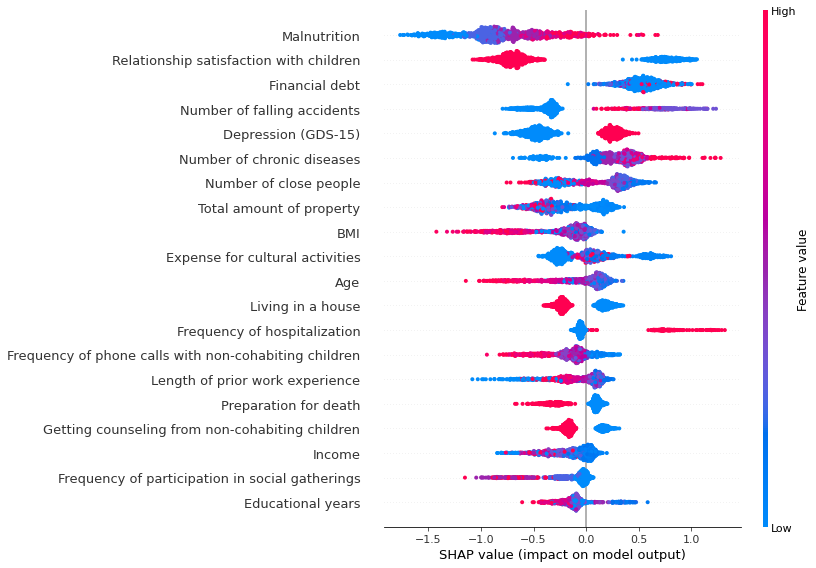

In [58]:
shap.summary_plot(shap_values, df, max_display=20)

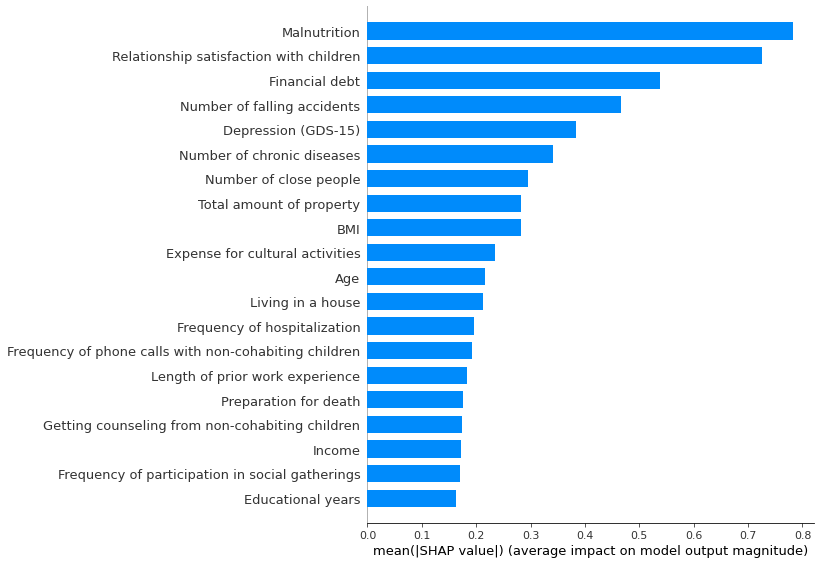

In [59]:
shap.summary_plot(shap_values, df, plot_type="bar", max_display=20)

In [ ]:
data_path = '/content/gdrive/My Drive/성은이파이썬/ICT_ML/data/2017_NSOK_test_preprocessed_2.csv'

ex_val_data = pd.read_csv(data_path) ## sperater, delimiter 확인
ex_val_data = ex_val_data.drop('Unnamed: 0', axis=1)


X_ex_val = ex_val_data.drop('suicide', axis=1)
y_ex_val = ex_val_data['suicide']

In [ ]:
col_dict = {
'H16_4_y' : 'Relationship satisfaction with children',
'nutrition' : 'Malnutrition',
'J6b_4_y' : 'Financial debt',
'H12_1_etc_y' : 'Number of falling accidents',
'gds15_i' : 'Depression (GDS-15)',
'financial_asset' : 'Total amount of property',
'B2_3_y' : 'Number of chronic diseases',
'num_alter' : 'Number of close people',
'bmi' : 'BMI',
'H16_2_y' : 'Subjective economic satisfaction',
'RES_AGE_y' : 'Age',
'J1b_3_y' : 'Expense for cultural activities',
'B5_1_etc_1_y' : 'Number of medical institution visits',
'Q1_y_1': 'Living in a house',
'J3b_1_13_y' : 'Income',
'death_prep' : 'Preparation for death',
'RES_EDU2_y' : 'Educational years',
'G2_3_1_y' : 'Getting counseling from non-cohabiting children',
'call_child_out' : 'Frequency of phone calls with non-cohabiting children',
'E2_2_1_y' : 'Length of prior work experience',
}


X_ex_val_r = X_ex_val.rename(columns=col_dict)
df = X_ex_val_r.sample(n=1000, random_state = 1120)

In [ ]:
shap_values = explainer.shap_values(df, check_additivity=False)

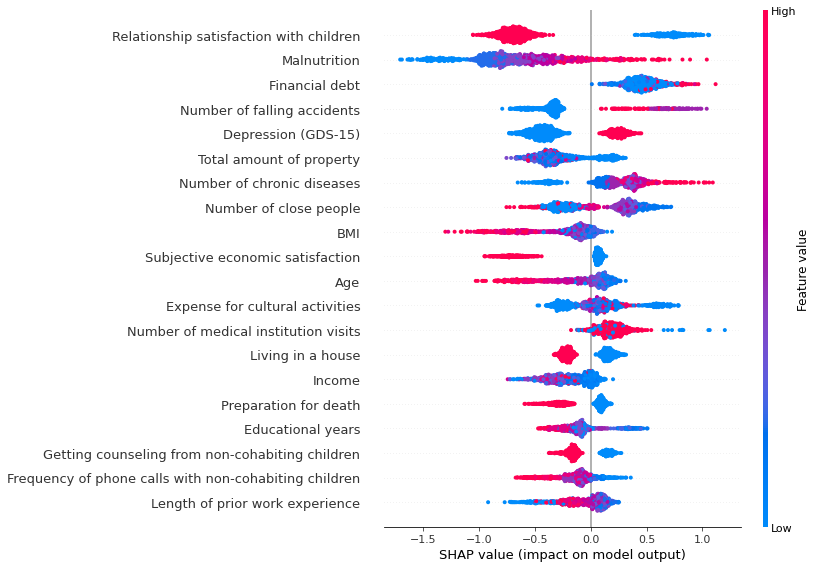

In [ ]:
shap.summary_plot(shap_values, df, max_display=20)

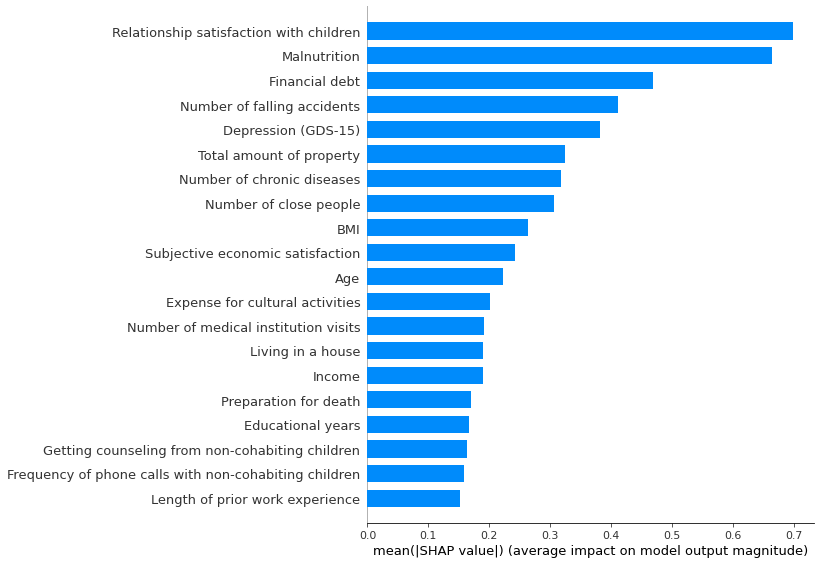

In [ ]:
shap.summary_plot(shap_values, df, plot_type="bar", max_display=20)

In [ ]:
data_path = '/content/gdrive/My Drive/성은이파이썬/ICT_ML/data/2020_NSOK_test_preprocessed_2.csv'

ex_val_data = pd.read_csv(data_path) ## sperater, delimiter 확인
ex_val_data = ex_val_data.drop('Unnamed: 0', axis=1)

X_ex_val = ex_val_data.drop('suicide', axis=1)
y_ex_val = ex_val_data['suicide']

In [ ]:
col_dict = {
'nutrition' : 'Malnutrition',
'H16_4_y' : 'Relationship satisfaction with children',
'J6b_4_y' : 'Financial debt',
'H12_1_etc_y' : 'Number of falling accidents',
'gds15_i' : 'Depression (GDS-15)',
'financial_asset' : 'Total amount of property',
'H16_2_y' : 'Subjective economic satisfaction',
'B2_3_y' : 'Number of chronic diseases',
'num_alter' : 'Number of close people',
'bmi' : 'BMI',
'RES_AGE_y' : 'Age',
'J3b_1_13_y' : 'Income',
'death_prep' : 'Preparation for death',
'J1b_3_y' : 'Expense for cultural activities',
'Q1_y_1': 'Living in a house',
'E2_2_1_y' : 'Length of prior work experience',    
'G2_3_1_y' : 'Getting counseling from non-cohabiting children',
'family_contact' : 'Frequency of contacting family members (siblings and relatives)',
'J1b_4_y' : 'Expenditure for congratulatory and condolence',
'RES_EDU2_y' : 'Educational years',
}


X_ex_val = X_ex_val.rename(columns=col_dict)
df = X_ex_val.sample(n=1000, random_state = 1120)

In [ ]:
shap_values = explainer.shap_values(df, check_additivity=False)

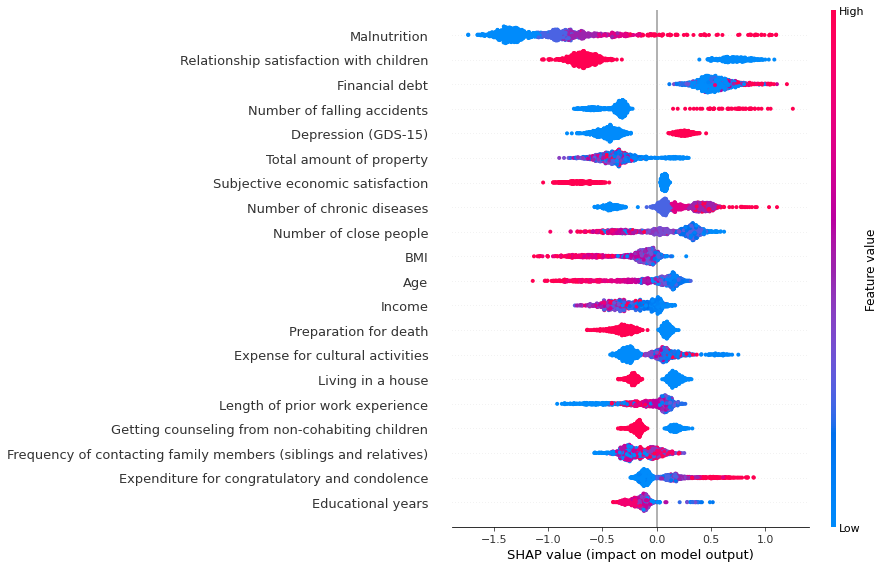

In [ ]:
shap.summary_plot(shap_values, df, max_display=20)

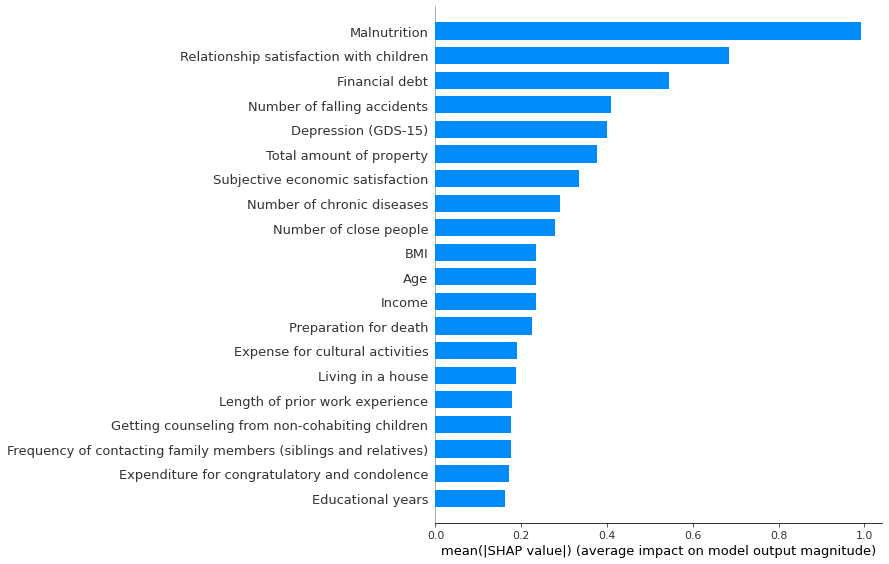

In [ ]:
shap.summary_plot(shap_values, df, plot_type="bar", max_display=20)

## ROC curve

In [ ]:
# model_file_path = "/content/gdrive/My Drive/성은이파이썬/ICT_ML/model/model_LR.model"  
# result_lr = joblib.load(model_file_path)

# model_file_path = "/content/gdrive/My Drive/성은이파이썬/ICT_ML/model/model_RF.model"  
# result_RF = joblib.load(model_file_path)

# model_file_path = "/content/gdrive/My Drive/성은이파이썬/ICT_ML/model/model_MLP.model"  
# result_MLP = joblib.load(model_file_path)

# model_file_path = "/content/gdrive/My Drive/성은이파이썬/ICT_ML/model/model_XGB.model"  
# result_XGB = joblib.load(model_file_path)

In [ ]:
# from sklearn import metrics
# import numpy as np
# import matplotlib.pyplot as plt

# y_test_pred  = result.predict(X_test)
# y_test_prob = result.predict_proba(X_test)

# y_ex_val, y_ex_val_pred

# plt.figure(0).clf()

# pred = np.random.rand(1000)
# label = np.random.randint(2, size=1000)
# fpr, tpr, thresh = metrics.roc_curve(label, pred)
# auc = metrics.roc_auc_score(label, pred)
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

# pred = np.random.rand(1000)
# label = np.random.randint(2, size=1000)
# fpr, tpr, thresh = metrics.roc_curve(label, pred)
# auc = metrics.roc_auc_score(label, pred)
# plt.plot(fpr,tpr,label="data 2, auc="+str(auc))

# plt.legend(loc=0)